In [279]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
import pytesseract

plt.rcParams['figure.figsize'] = [10, 8]

### First load the image for analysis...

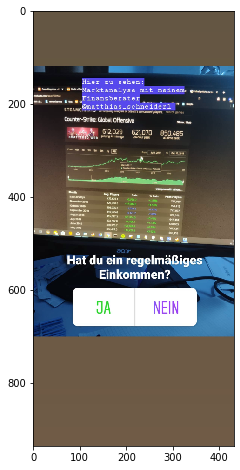

In [280]:
img = cv2.imread("../test/data/story.jpg")
img = cv2.resize(img, (int(img.shape[1] * 0.4), int(img.shape[0] * 0.4)), interpolation=cv2.INTER_AREA)

def display_image_plot(_img):
    if len(_img) == 3:
        plt.imshow(_img[:,:,::-1])
    else:
        plt.imshow(_img, cmap='gray')
        
def display_image(_img):
    cv2.imshow("", _img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
display_image_plot(img)

### Analysis

Try to find the rectangle containing the choices for the story.

The box is always pure #FFFFFF, so filter for color first, to find the location of the box.

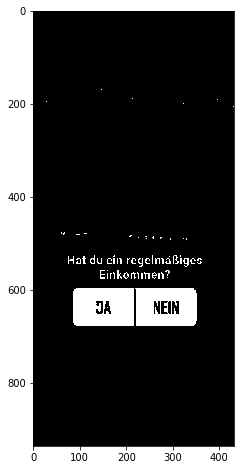

In [281]:
img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

mask = cv2.inRange(img_gs, np.array([250]), np.array([255]))

display_image_plot(mask)

Now find the contour of the big box and discard elements smaller than the biggest two elements.

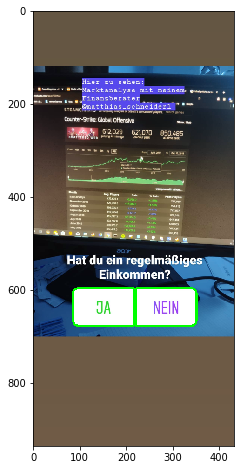

In [282]:
CONTOUR_MIN=1000
CONTOUR_MAX=20000

contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_filtered = list(filter(lambda x: CONTOUR_MIN < cv2.contourArea(x) < CONTOUR_MAX, contours))

display_image_plot(cv2.drawContours(img.copy(), contours_filtered, -1, (0, 255, 0), 3))

Finally, we need to isolate the yes/no dialog => Find matching shapes. First save the found contours to json.

In [283]:
yes_contour = contours_filtered[1]
no_contour = contours_filtered[0]

json_string = json.dumps({
    "yes": yes_contour.tolist(),
    "no": no_contour.tolist()
})

json_string

'{"yes": [[[94, 596]], [[92, 598]], [[90, 598]], [[88, 600]], [[88, 601]], [[86, 603]], [[86, 669]], [[87, 670]], [[87, 671]], [[88, 672]], [[88, 673]], [[89, 674]], [[90, 674]], [[91, 675]], [[92, 675]], [[93, 676]], [[95, 676]], [[96, 677]], [[216, 677]], [[216, 596]]], "no": [[[221, 596]], [[220, 597]], [[221, 598]], [[221, 677]], [[341, 677]], [[342, 676]], [[344, 676]], [[345, 675]], [[346, 675]], [[349, 672]], [[349, 671]], [[350, 670]], [[350, 668]], [[351, 667]], [[351, 606]], [[350, 605]], [[350, 603]], [[349, 602]], [[349, 601]], [[348, 600]], [[347, 600]], [[346, 599]], [[346, 598]], [[345, 598]], [[344, 597]], [[343, 597]], [[342, 596]]]}'

Now filter the contours by yes and no contour.

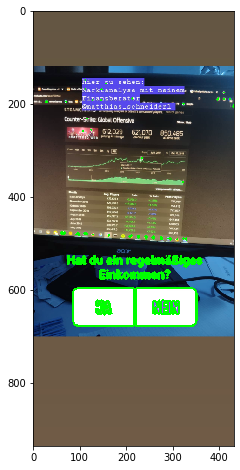

In [284]:
contours_matched_shapes = list(filter(lambda x: 0.01 > cv2.matchShapes(x, contours_filtered[0], 1, 0.0), contours))

display_image_plot(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3))

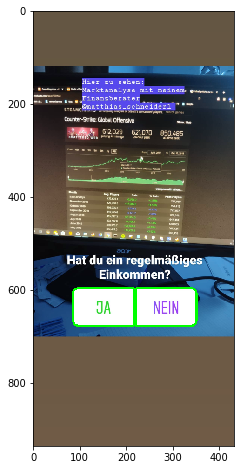

In [285]:
display_image_plot(cv2.drawContours(img.copy(), contours_matched_shapes, -1, (0, 255, 0), 3))

Now try to detect text using tesseract.

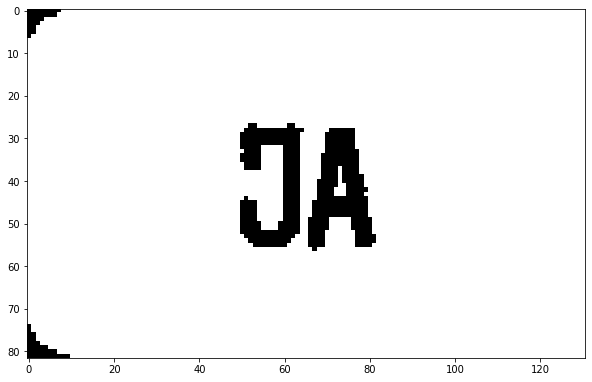

In [286]:
# find text of yes/no

(yx, yy, yw, yh) = cv2.boundingRect(yes_contour)
(nx, ny, nw, nh) = cv2.boundingRect(no_contour)

img_yes = mask[yy:yy+yh,yx:yx+yw]
img_no = mask[ny:ny+nh,nx:nx+nw]

display_image_plot(img_yes)

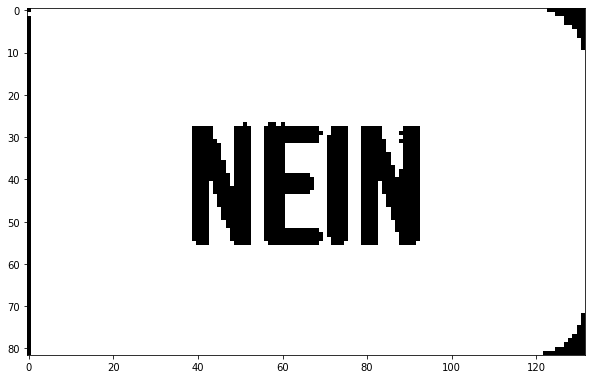

In [287]:
display_image_plot(img_no)

In [312]:
img_no = cv2.cvtColor(img_no, cv2.COLOR_BGR2RGB)
img_yes = cv2.cvtColor(img_yes, cv2.COLOR_BGR2RGB)

pytesseract.image_to_string(img_yes, lang="deu+eng", config="--dpi 100"), pytesseract.image_to_string(img_no, lang="deu+eng")

('3A', 'NEIN')